# Redes Neuronales Recurrentes con TensorFlow

En este ejercicio vamos a realizar una primera experimentación con redes neuronales recurrentes en TensorFlow.

In [1]:
import tensorflow as tf

# Usaremos un DataFrame de pandas para guardar la información de los experimentos
import pandas as pd
resultados = pd.DataFrame(columns=['modelo', 'num_units', 'num_epochs', 'exactitud (accuracy)', 'train_logdir'])

## 1. RNN *many-to-one* para clasificación de MNIST

Si tratamos cada imagen MNIST de un alto *h* y ancho *w* como una secuencia de *h* vectores de *w* elementos, podemos emplear una red neuronal para predecir su clase, esto es, el dígito que representa.

### 1.1. Cargar el conjunto de datos

En primer lugar cargamos el conjunto de datos tal como lo hemos hecho antes.

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=False)

print('Entrenamiento: ', mnist.train.images.shape, mnist.train.labels.shape)
print('Validación: ', mnist.validation.images.shape, mnist.validation.labels.shape)
print('Pruebas: ', mnist.test.images.shape, mnist.test.labels.shape)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Entrenamiento:  (55000, 28, 28, 1) (55000, 10)
Validación:  (5000, 28, 28, 1) (5000, 10)
Pruebas:  (10000, 28, 28, 1) (10000, 10)


### 1.2. Crear el grafo

#### Dimensiones del modelo

In [3]:
#########################
# DIMENSIONES DEL MODELO
#########################

# Longitud de las secuencias: cada imagen tiene 28 filas (alto)
num_steps = mnist.train.images.shape[1]

# Capa de entrada: cada paso será una fila de 28 pixeles (ancho)
input_size = mnist.train.images.shape[2]

# Número de unidades en las unidades ocultas
num_units = 128

# Número de clases: 10 dígitos diferentes
num_classes = mnist.train.labels.shape[1]

#### Tensores para las entradas y parámetros

Creamos los tensores para los datos de entrada y para los parámetros. Inicializamos los pesos $U$, $W$ y $V$ con el inicializador *Xavier*, esto es, con una distribución aleatoria uniforme en el rango $[-r, +r]$, donde $r = \sqrt{\frac{6}{n_{inputs} + n_{outputs}}}$. Inicializamos los biases $b$ y $c$ con ceros.

In [4]:
tf.reset_default_graph()

####################
# TENSORES
####################

# Datos de entrada
with tf.name_scope("inputs"):
  x = tf.placeholder(tf.float32, [None, num_steps, input_size, 1], name="x")
  labels = tf.placeholder(tf.float32, [None, num_classes], name="labels")
  x_reshaped = tf.reshape(x, [-1, num_steps, input_size], name="x_reshaped")

# Parámetros del modelo (pesos y biases)
with tf.variable_scope("parameters", initializer=tf.contrib.layers.xavier_initializer()):
  U = tf.get_variable("U", [input_size, num_units])
  W = tf.get_variable("W", [num_units, num_units])
  V = tf.get_variable("V", [num_units, num_classes])
  
with tf.variable_scope("parameters", initializer=tf.constant_initializer(0.)):
  b = tf.get_variable("b", [num_units])
  c = tf.get_variable("c", [num_classes])

#### Operaciones del modelo

Definimos primero una función `next_h` para calcular cada $\textbf{h}^{(t)}$ a partir de $\textbf{h}^{(t-1)}$ y $\textbf{x}^{(t)}$. 

$\textbf{a}^{(t)}  = \textbf{b} + \textbf{W}\textbf{h}^{(t-1)} + \textbf{U}\textbf{x}^{(t)}$

$\textbf{h}^{(t)}  = tanh(\textbf{a}^{(t)})$

En el código de abajo las multiplicaciones de matrices se encuentran invertidas en relacion a las ecuaciones porque estamos procesando en lotes las imágenes de entrada y TensorFlow espera recibir los datos con `batch_size` como la primera dimensión (no sería así si pusiésemos `batch_size` como última dimensión).

Luego inicializamos $\textbf{h}^{(0)}$ con ceros y ejecutamos el cálculo recurrente con el método `tf.scan`, que nos devuelve en la variable `h_outputs` los estados $\textbf{h}^{(1)}, ..., \textbf{h}^{(t)}$.

Con el estado final `h_state` hacemos el cálculo de $o$ (`logits`), de las probabilidades normalizadas (`y_prob`) y de $\hat{y}$ (`y_predictions`).

In [5]:
#########################
# OPERACIONES DEL MODELO
#########################

def next_h(h_prev, x_t):
  with tf.variable_scope("parameters", reuse=True):
    U = tf.get_variable("U")
    W = tf.get_variable("W")
    b = tf.get_variable("b")
  a_t = b + tf.matmul(h_prev, W) + tf.matmul(x_t, U)
  h_t = tf.tanh(a_t)
  return h_t

with tf.name_scope("model"):
  with tf.name_scope("hidden"):
    h_0 = tf.zeros([tf.shape(x)[0], num_units], name="h_0")
    h_outputs = tf.scan(next_h, 
                        tf.transpose(x_reshaped, [1,0,2]),  # [num_steps, batch_size, num_inputs])
                        initializer=h_0,
                        name="h_outputs"
                       )
    h_state = h_outputs[-1]
    h_outputs = tf.transpose(h_outputs, [1,0,2], name="reshaped_h_outputs")  # [batch_size, num_steps, num_units]
  
  with tf.name_scope("output"):
    logits = c + tf.matmul(h_state, V)
    y_probs = tf.nn.softmax(logits)
    y_predictions = tf.argmax(y_probs, axis=1)

El resto de operaciones son las mismas que cuando vimos MNIST con CNN.

In [6]:
#########################
# OPERACIONES DE ENTRENAMIENTO
#########################

with tf.name_scope("train"):
  cost = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
  loss = tf.reduce_mean(cost)
  optimizer = tf.train.AdamOptimizer()
  training_op = optimizer.minimize(loss)
  

#########################
# OPERACIONES DE EVALUACIÓN Y VISUALIZACIÓN
#########################

with tf.name_scope("eval"):
  y = tf.argmax(labels, axis=1)
  correct = tf.nn.in_top_k(logits, y, 1)
  accuracy = tf.reduce_mean(tf.to_float(correct))

with tf.name_scope("summaries"):
  acc_summary = tf.summary.scalar('accuracy', accuracy)
  loss_summary = tf.summary.scalar('loss', loss)
  merged = tf.summary.merge_all()

### 1.3. Ejecutar el grafo

Esta parte es también igual al modelo con CNN.

In [7]:
nombre_del_experimento = "RNN simple, many-to-one"

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S") 
root_logdir = "/tmp/rnn-mnist" 
train_logdir = "{}/run-{}-train".format(root_logdir, now)
val_logdir = "{}/run-{}-val".format(root_logdir, now)
train_file_writer = tf.summary.FileWriter(train_logdir, tf.get_default_graph())
val_file_writer = tf.summary.FileWriter(val_logdir)

print("=====================================================")
print("Epoch  Train_loss  Train_acc   Val_loss    Val_acc")
print("-----------------------------------------------------")


num_epochs = 20
batch_size = 2048
num_batches_per_epoch = mnist.train.num_examples // batch_size

with tf.Session() as sess: 
  
  tf.global_variables_initializer().run()
  
  for epoch in range(num_epochs):
    for step in range(num_batches_per_epoch):
      cur_step = epoch * num_batches_per_epoch + step
      batch_images, batch_labels = mnist.train.next_batch(batch_size)
      _, train_loss, train_acc, summary = sess.run([training_op, loss, accuracy, merged], 
                                                     feed_dict={x: batch_images, labels: batch_labels})
      train_file_writer.add_summary(summary, cur_step + 1)
      
    val_loss, val_acc, summary = sess.run([loss, accuracy, merged], 
                                          feed_dict={x: mnist.validation.images, labels: mnist.validation.labels})
    val_file_writer.add_summary(summary, cur_step )
    print("{:04d}{:12.7f}{:12.7f}{:12.7f}{:12.7f}".format
          (epoch+1, train_loss, train_acc, val_loss, val_acc))

  test_acc = sess.run([accuracy], 
                      feed_dict={x: mnist.test.images, labels: mnist.test.labels})
print("-----------------------------------------------------")
print("Test accuracy:", test_acc)
print("=====================================================")

train_file_writer.close()
val_file_writer.close()

## Añadimos nuestros resultados al dataframe
idx = len(resultados)
resultados.loc[idx] = [nombre_del_experimento,
                       num_units,
                       num_epochs,
                       test_acc,
                       train_logdir ]
resultados

Epoch  Train_loss  Train_acc   Val_loss    Val_acc
-----------------------------------------------------
0001   1.0620583   0.6875000   0.9877195   0.7188000
0002   0.5944891   0.8256836   0.5333630   0.8492000
0003   0.4114968   0.8740234   0.3769458   0.8932000
0004   0.3136585   0.9091797   0.2986721   0.9128000
0005   0.2907442   0.9135742   0.2538413   0.9280000
0006   0.2451400   0.9287109   0.2169101   0.9400000
0007   0.2288777   0.9306641   0.1956740   0.9460000
0008   0.2024334   0.9321289   0.1784340   0.9524000
0009   0.1483473   0.9609375   0.1668845   0.9524000
0010   0.1442550   0.9609375   0.1499246   0.9604000
0011   0.1632075   0.9531250   0.1427756   0.9624000
0012   0.1496067   0.9584961   0.1368400   0.9620000
0013   0.1152981   0.9677734   0.1298203   0.9652000
0014   0.1594123   0.9521484   0.1269386   0.9656000
0015   0.1228817   0.9589844   0.1178786   0.9692000
0016   0.1226587   0.9648438   0.1165135   0.9690000
0017   0.1045801   0.9677734   0.1103347   0.97

,modelo,num_units,num_epochs,exactitud (accuracy),train_logdir
0,"RNN simple, many-to-one",128,20,[0.9664],/tmp/rnn-mnist/run-20171207015933-train


Podemos visualizar el entrenamiento con el comando (corregir la letra del disco): 

`tensorboard --logdir="d:/tmp/rnn-mnist"` 

### 1.4. Refactorización del código para usar las funciones `BasicRNNCell` y `dynamic_rnn`

La función [`tf.contrib.rnn.BasicRNNCell`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/BasicRNNCell) crea una celda RNN básica como la que hemos usado y la función [tf.nn.dynamic_rnn](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn) crea una RNN compuesta del tipo de celdas que le sean indicadas, realizando un despliegue completamente dinámico de sus entradas:

```python
    rnn_cell = tf.contrib.rnn.BasicRNNCell(num_units)
    h_outputs, h_state = tf.nn.dynamic_rnn(cell=rnn_cell, inputs=x_reshaped, dtype=tf.float32)
```
* Consolida el código de las secciones 1.2 y 1.3 en una celda cada uno.

* Modifica el código para usar las funciones `BasicRNNCell` y `dynamic_rnn`. Ya no necesitas declarar manualmente los pesos `U` y `W`, ni el bias `b`. Deshabilita las líneas correspondientes anteponiéndoles un `#`

* Tampoco necesitas la función `next_h`. Elimínala o deshabilítala también.

* Finalmente reemplaza todo el código correspondiente al `name_scope("hidden")` por las dos líneas de arriba y ejecuta el grafo.

In [8]:
#########################
# DIMENSIONES DEL MODELO
#########################

# Longitud de las secuencias: cada imagen tiene 28 filas (alto)
num_steps = mnist.train.images.shape[1]

# Capa de entrada: cada paso será una fila de 28 pixeles (ancho)
input_size = mnist.train.images.shape[2]

# Número de unidades en las unidades ocultas
num_units = 128

# Número de clases: 10 dígitos diferentes
num_classes = mnist.train.labels.shape[1]

tf.reset_default_graph()

####################
# TENSORES
####################

# Datos de entrada
with tf.name_scope("inputs"):
  x = tf.placeholder(tf.float32, [None, num_steps, input_size, 1], name="x")
  labels = tf.placeholder(tf.float32, [None, num_classes], name="labels")
  x_reshaped = tf.reshape(x, [-1, num_steps, input_size], name="x_reshaped")

# Parámetros del modelo (pesos y biases)
with tf.variable_scope("parameters", initializer=tf.contrib.layers.xavier_initializer()):
  U = tf.get_variable("U", [input_size, num_units])
  W = tf.get_variable("W", [num_units, num_units])
  V = tf.get_variable("V", [num_units, num_classes])
  
with tf.variable_scope("parameters", initializer=tf.constant_initializer(0.)):
  b = tf.get_variable("b", [num_units])
  c = tf.get_variable("c", [num_classes])
  
#########################
# OPERACIONES DEL MODELO
#########################

'''
def next_h(h_prev, x_t):
  with tf.variable_scope("parameters", reuse=True):
    U = tf.get_variable("U")
    W = tf.get_variable("W")
    b = tf.get_variable("b")
  a_t = b + tf.matmul(h_prev, W) + tf.matmul(x_t, U)
  h_t = tf.tanh(a_t)
  return h_t
'''

with tf.name_scope("model"):
  with tf.name_scope("hidden"):    
    rnn_cell = tf.contrib.rnn.BasicRNNCell(num_units)
    h_outputs, h_state = tf.nn.dynamic_rnn(cell=rnn_cell, inputs=x_reshaped, dtype=tf.float32)
    '''
    h_0 = tf.zeros([tf.shape(x)[0], num_units], name="h_0")
    h_outputs = tf.scan(next_h, 
                        tf.transpose(x_reshaped, [1,0,2]),  # [num_steps, batch_size, num_inputs])
                        initializer=h_0,
                        name="h_outputs"
                       )
    h_state = h_outputs[-1]
    h_outputs = tf.transpose(h_outputs, [1,0,2], name="reshaped_h_outputs")  # [batch_size, num_steps, num_units]
    '''
    
  with tf.name_scope("output"):
    logits = c + tf.matmul(h_state, V)
    y_probs = tf.nn.softmax(logits)
    y_predictions = tf.argmax(y_probs, axis=1)
    
#########################
# OPERACIONES DE ENTRENAMIENTO
#########################

with tf.name_scope("train"):
  cost = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
  loss = tf.reduce_mean(cost)
  optimizer = tf.train.AdamOptimizer()
  training_op = optimizer.minimize(loss)
  

#########################
# OPERACIONES DE EVALUACIÓN Y VISUALIZACIÓN
#########################

with tf.name_scope("eval"):
  y = tf.argmax(labels, axis=1)
  correct = tf.nn.in_top_k(logits, y, 1)
  accuracy = tf.reduce_mean(tf.to_float(correct))

with tf.name_scope("summaries"):
  acc_summary = tf.summary.scalar('accuracy', accuracy)
  loss_summary = tf.summary.scalar('loss', loss)
  merged = tf.summary.merge_all()

In [9]:
nombre_del_experimento = "BasicRNNCell, many-to-one"

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S") 
root_logdir = "/tmp/rnn-mnist" 
train_logdir = "{}/run-{}-train".format(root_logdir, now)
val_logdir = "{}/run-{}-val".format(root_logdir, now)
train_file_writer = tf.summary.FileWriter(train_logdir, tf.get_default_graph())
val_file_writer = tf.summary.FileWriter(val_logdir)

print("=====================================================")
print("Epoch  Train_loss  Train_acc   Val_loss    Val_acc")
print("-----------------------------------------------------")


num_epochs = 20
batch_size = 2048
num_batches_per_epoch = mnist.train.num_examples // batch_size

with tf.Session() as sess: 
  
  tf.global_variables_initializer().run()
  
  for epoch in range(num_epochs):
    for step in range(num_batches_per_epoch):
      cur_step = epoch * num_batches_per_epoch + step
      batch_images, batch_labels = mnist.train.next_batch(batch_size)
      _, train_loss, train_acc, summary = sess.run([training_op, loss, accuracy, merged], 
                                                     feed_dict={x: batch_images, labels: batch_labels})
      train_file_writer.add_summary(summary, cur_step + 1)
      
    val_loss, val_acc, summary = sess.run([loss, accuracy, merged], 
                                          feed_dict={x: mnist.validation.images, labels: mnist.validation.labels})
    val_file_writer.add_summary(summary, cur_step )
    print("{:04d}{:12.7f}{:12.7f}{:12.7f}{:12.7f}".format
          (epoch+1, train_loss, train_acc, val_loss, val_acc))

  test_acc = sess.run([accuracy], 
                      feed_dict={x: mnist.test.images, labels: mnist.test.labels})
print("-----------------------------------------------------")
print("Test accuracy:", test_acc)
print("=====================================================")

train_file_writer.close()
val_file_writer.close()

## Añadimos nuestros resultados al dataframe
idx = len(resultados)
resultados.loc[idx] = [nombre_del_experimento,
                       num_units,
                       num_epochs,
                       test_acc,
                       train_logdir ]
resultados

Epoch  Train_loss  Train_acc   Val_loss    Val_acc
-----------------------------------------------------
0001   1.1381664   0.6240234   1.0820074   0.6514000
0002   0.7580898   0.7500000   0.7451014   0.7700000
0003   0.5452777   0.8354492   0.4775521   0.8640000
0004   0.3907683   0.8842773   0.3636132   0.8986000
0005   0.3534286   0.8916016   0.3013775   0.9138000
0006   0.2963310   0.9174805   0.2670401   0.9248000
0007   0.2944254   0.9184570   0.2409909   0.9300000
0008   0.2633553   0.9267578   0.2340029   0.9330000
0009   0.2081070   0.9409180   0.2138777   0.9402000
0010   0.2108822   0.9375000   0.2217248   0.9362000
0011   0.2147555   0.9418945   0.1900247   0.9444000
0012   0.2078836   0.9345703   0.1852503   0.9464000
0013   0.1706168   0.9467773   0.1732341   0.9506000
0014   0.1983017   0.9394531   0.1671678   0.9530000
0015   0.1534166   0.9541016   0.1698672   0.9536000
0016   0.1594216   0.9521484   0.1643154   0.9512000
0017   0.1743040   0.9482422   0.1545998   0.95

,modelo,num_units,num_epochs,exactitud (accuracy),train_logdir
0,"RNN simple, many-to-one",128,20,[0.9664],/tmp/rnn-mnist/run-20171207015933-train
1,"BasicRNNCell, many-to-one",128,20,[0.9576],/tmp/rnn-mnist/run-20171207015939-train


## 2. RNN *many-to-many* para clasificación de MNIST

### 2.1. RNN *many-to-many* de una capa

En la primera parte hemos empleado una RNN *many-to-one*, entrenada para clasificar el dígito correspondiente a una imagen MNIST interpretada como una secuencia de filas de pixeles. Ahora experimentaremos con una RNN que intente predecir el dígito de la imagen desde cada estado de la RNN.

Para ello, en lugar de calcular los `logits` sólo desde el estado final, los calcularemos desde cada estado. Con ello, sus dimensiones serán ahora `[batch_size, n_steps, num_classes]` 

Haz los siguientes cambios:

* En la sección `tf.name_scope("inputs")` genera una versión de `labels` "expandida" por el número de pasos.
```python
labels_per_step = tf.reshape(tf.tile(labels, [1, num_steps]), [-1, num_classes])
```
* En la sección `tf.name_scope("output")` añade el siguiente código para hacer predicciones en cada paso:
```python
    h_outputs = tf.reshape(h_outputs, [-1, num_units])
    logits_per_step = c + tf.matmul(h_outputs, V)
    logits_per_step_reshaped = tf.reshape(logits_per_step, [-1, num_steps, num_classes])
    y_probs_per_step = tf.nn.softmax(logits_per_step_reshaped)
    y_predictions_per_step = tf.argmax(y_probs_per_step, axis=2) 
```
* En la sección `tf.name_scope("train")` modifica la función de costo para que calcule la entropía cruzada usando `labels_per_step` y `logits_per_step`.

En la ejecución solamente incluiremos la consulta a las predicciones y probabilidades por cada paso en el conjunto de prueba:
```python
  test_acc, test_probs, test_predictions = sess.run([accuracy, y_probs_per_step, y_predictions_per_step], 
                                                    feed_dict={x: mnist.test.images, labels: mnist.test.labels})
```

In [13]:
#########################
# DIMENSIONES DEL MODELO
#########################

# Longitud de las secuencias: cada imagen tiene 28 filas (alto)
num_steps = mnist.train.images.shape[1]

# Capa de entrada: cada paso será una fila de 28 pixeles (ancho)
input_size = mnist.train.images.shape[2]

# Número de unidades en las unidades ocultas
num_units = 128

# Número de clases: 10 dígitos diferentes
num_classes = mnist.train.labels.shape[1]

tf.reset_default_graph()

####################
# TENSORES
####################

# Datos de entrada
with tf.name_scope("inputs"):
  x = tf.placeholder(tf.float32, [None, num_steps, input_size, 1], name="x")
  labels = tf.placeholder(tf.float32, [None, num_classes], name="labels")
  labels_per_step = tf.reshape(tf.tile(labels, [1, num_steps]), [-1, num_classes])
  x_reshaped = tf.reshape(x, [-1, num_steps, input_size], name="x_reshaped")

# Parámetros del modelo (pesos y biases)
with tf.variable_scope("parameters", initializer=tf.contrib.layers.xavier_initializer()):
  U = tf.get_variable("U", [input_size, num_units])
  W = tf.get_variable("W", [num_units, num_units])
  V = tf.get_variable("V", [num_units, num_classes])
  
with tf.variable_scope("parameters", initializer=tf.constant_initializer(0.)):
  b = tf.get_variable("b", [num_units])
  c = tf.get_variable("c", [num_classes])
  
#########################
# OPERACIONES DEL MODELO
#########################

'''
def next_h(h_prev, x_t):
  with tf.variable_scope("parameters", reuse=True):
    U = tf.get_variable("U")
    W = tf.get_variable("W")
    b = tf.get_variable("b")
  a_t = b + tf.matmul(h_prev, W) + tf.matmul(x_t, U)
  h_t = tf.tanh(a_t)
  return h_t
'''

with tf.name_scope("model"):
  with tf.name_scope("hidden"):    
    rnn_cell = tf.contrib.rnn.BasicRNNCell(num_units)
    h_outputs, h_state = tf.nn.dynamic_rnn(cell=rnn_cell, inputs=x_reshaped, dtype=tf.float32)
    '''
    h_0 = tf.zeros([tf.shape(x)[0], num_units], name="h_0")
    h_outputs = tf.scan(next_h, 
                        tf.transpose(x_reshaped, [1,0,2]),  # [num_steps, batch_size, num_inputs])
                        initializer=h_0,
                        name="h_outputs"
                       )
    h_state = h_outputs[-1]
    h_outputs = tf.transpose(h_outputs, [1,0,2], name="reshaped_h_outputs")  # [batch_size, num_steps, num_units]
    '''
    
  with tf.name_scope("output"):
    logits = c + tf.matmul(h_state, V)
    y_probs = tf.nn.softmax(logits)
    y_predictions = tf.argmax(y_probs, axis=1)
    h_outputs = tf.reshape(h_outputs, [-1, num_units])
    
    logits_per_step = c + tf.matmul(h_outputs, V)
    logits_per_step_reshaped = tf.reshape(logits_per_step, [-1, num_steps, num_classes])
    y_probs_per_step = tf.nn.softmax(logits_per_step_reshaped)
    y_predictions_per_step = tf.argmax(y_probs_per_step, axis=2)
    
#########################
# OPERACIONES DE ENTRENAMIENTO
#########################

with tf.name_scope("train"):
  #cost = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
  cost = tf.nn.softmax_cross_entropy_with_logits(labels=labels_per_step, logits=logits_per_step)
  loss = tf.reduce_mean(cost)
  optimizer = tf.train.AdamOptimizer()
  training_op = optimizer.minimize(loss)
  

#########################
# OPERACIONES DE EVALUACIÓN Y VISUALIZACIÓN
#########################

with tf.name_scope("eval"):
  y = tf.argmax(labels, axis=1)
  correct = tf.nn.in_top_k(logits, y, 1)
  accuracy = tf.reduce_mean(tf.to_float(correct))

with tf.name_scope("summaries"):
  acc_summary = tf.summary.scalar('accuracy', accuracy)
  loss_summary = tf.summary.scalar('loss', loss)
  merged = tf.summary.merge_all()

In [14]:
nombre_del_experimento = "BasicRNNCell, many-to-many"

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S") 
root_logdir = "/tmp/rnn-mnist" 
train_logdir = "{}/run-{}-train".format(root_logdir, now)
val_logdir = "{}/run-{}-val".format(root_logdir, now)
train_file_writer = tf.summary.FileWriter(train_logdir, tf.get_default_graph())
val_file_writer = tf.summary.FileWriter(val_logdir)

print("=====================================================")
print("Epoch  Train_loss  Train_acc   Val_loss    Val_acc")
print("-----------------------------------------------------")


num_epochs = 20
batch_size = 2048
num_batches_per_epoch = mnist.train.num_examples // batch_size

with tf.Session() as sess: 
  
  tf.global_variables_initializer().run()
  
  for epoch in range(num_epochs):
    for step in range(num_batches_per_epoch):
      cur_step = epoch * num_batches_per_epoch + step
      batch_images, batch_labels = mnist.train.next_batch(batch_size)
      _, train_loss, train_acc, summary = sess.run([training_op, loss, accuracy, merged], 
                                                     feed_dict={x: batch_images, labels: batch_labels})
      train_file_writer.add_summary(summary, cur_step + 1)
      
    val_loss, val_acc, summary = sess.run([loss, accuracy, merged], 
                                          feed_dict={x: mnist.validation.images, labels: mnist.validation.labels})
    val_file_writer.add_summary(summary, cur_step )
    print("{:04d}{:12.7f}{:12.7f}{:12.7f}{:12.7f}".format
          (epoch+1, train_loss, train_acc, val_loss, val_acc))

  #test_acc = sess.run([accuracy], 
  #                    feed_dict={x: mnist.test.images, labels: mnist.test.labels})
  test_acc, test_probs, test_predictions = sess.run([accuracy, y_probs_per_step, y_predictions_per_step], 
                                                    feed_dict={x: mnist.test.images, labels: mnist.test.labels})
print("-----------------------------------------------------")
print("Test accuracy:", test_acc)
print("=====================================================")

train_file_writer.close()
val_file_writer.close()

## Añadimos nuestros resultados al dataframe
idx = len(resultados)
resultados.loc[idx] = [nombre_del_experimento,
                       num_units,
                       num_epochs,
                       test_acc,
                       train_logdir ]
resultados

Epoch  Train_loss  Train_acc   Val_loss    Val_acc
-----------------------------------------------------
0001   1.9686178   0.3168945   1.9758295   0.3318000
0002   1.7462701   0.4487305   1.7369083   0.4428000
0003   1.5496877   0.5810547   1.5074592   0.6120000
0004   1.3473375   0.7285156   1.3414625   0.7398000
0005   1.2465600   0.7963867   1.2379891   0.7962000
0006   1.1631039   0.8330078   1.1623590   0.8300000
0007   1.1291684   0.8432617   1.1167397   0.8472000
0008   1.0863687   0.8691406   1.0680777   0.8758000
0009   1.0732927   0.8632812   1.0484580   0.8764000
0010   1.0432396   0.8842773   1.0132946   0.8958000
0011   1.0002620   0.9018555   0.9954647   0.9012000
0012   1.0242083   0.9023438   0.9773375   0.9020000
0013   0.9926221   0.8964844   0.9651242   0.9070000
0014   0.9669784   0.9082031   0.9534706   0.9114000
0015   0.9406610   0.9257812   0.9383736   0.9164000
0016   0.9428278   0.9165039   0.9250610   0.9222000
0017   0.9317504   0.9287109   0.9169464   0.92

,modelo,num_units,num_epochs,exactitud (accuracy),train_logdir
0,"RNN simple, many-to-one",128,20,[0.9664],/tmp/rnn-mnist/run-20171207015933-train
1,"BasicRNNCell, many-to-one",128,20,[0.9576],/tmp/rnn-mnist/run-20171207015939-train
2,"BasicRNNCell, many-to-many",128,20,0.9286,/tmp/rnn-mnist/run-20171207020736-train


Visualicemos las predicciones para cada uno de los pasos en una imagen cualquiera del conjunto de pruebas:

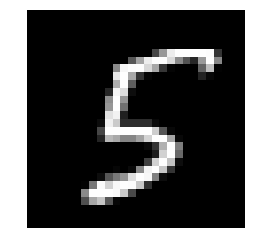

Filas                                                       Predicción     Probabilidad
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]        2         0.1113448
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]        1         0.1145547
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]        1         0.1185016
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]        1         0.1234492
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]        7         0.1447916
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0]        0         0.4434519
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0]        5         0.3027963
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0]        5         0.5446369
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]        5         0.6445640
[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]        5         0.7298463
[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]     

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.axis('off')

img_idx = 23  # Escoge el número de imagen que desees
mnist_image = mnist.test.images[img_idx].reshape(28,28)
binarized_img = (mnist_image > 0.5).astype(int)
plt.imshow(mnist.test.images[img_idx].reshape(28,28), cmap="gray")
plt.show()

print("{:60}{:15}{:10}".format(
  "Filas", 
  "Predicción",
  "Probabilidad"
     ))
  
for row in np.arange(28):
  print("{}{:9d}{:18.7f}".format(
    binarized_img[row], 
    test_predictions[img_idx,row],
    np.max(test_probs[img_idx,row])
    ))


## 2.2. Añadiendo profundidad a la capa oculta

Para usar una capa oculta con 2 (o más celdas) de profundidad, haz las siguientes modificaciones:
```python
...
# Número de capas RNN
num_rnn_layers = 2
...
  with tf.name_scope("hidden"):
    def rnn_cell():
      return tf.contrib.rnn.BasicRNNCell(num_units)
    multilayer_rnn_cell = tf.contrib.rnn.MultiRNNCell([rnn_cell() for _ in range(num_rnn_layers)])
    h_outputs, h_states = tf.nn.dynamic_rnn(cell=multilayer_rnn_cell, inputs=x_reshaped, dtype=tf.float32)
    h_state = h_states[-1]
...
```

Entrena el modelo por 20 épocas y visualiza las predicciones para cada paso.

In [ ]:
...

In [ ]:
nombre_del_experimento = "BasicRNNCell, many-to-many, 2 rnn layers"
...

In [ ]:
...